<a href="https://colab.research.google.com/github/sheikh495/Data_mining/blob/main/m7_group1_spooky3times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Performance and Changes

**BEFORE Performance**

The initial performance of the Naive Bayes model was as follows:

* **Accuracy:** 0.8272700384501627
* **Precision:** 0.828320900473428
* **Recall:** 0.8272700384501628
* **F1-score:** 0.8266307785636475
                                 

**AFTER Performance**
                                                                                
#### Accuracy (No Hyperparameters): 85.74%
                                                                                
Naive Bayes Model Metrics:
* **Accuracy**: 0.857437165224557
* **Precision**: 0.8603401059429225
* **Recall**: 0.857437165224557
* **F1-score**: 0.8563621384676696
                                                                                
#### Accuracy with CV and ParamGrid: 86.07%
Model Metrics with CV and ParamGrid:
* **Accuracy**: 0.8607334157395962
* **Precision**: 0.8621623915864016
* **Recall**: 0.8607334157395963
* **F1-score**: 0.8598233969003779
                               

Explain the improved performance achieved after implementing changes. Provide updated metrics and evaluation results.

1. `Added randomSplit instead of balanced records by authors. Balacing records seemed to negatively affect the prediction accuracy`

2. `Increased the train dataset to 90% to maximize model prediction accuracy.`
    - `At 75%, we dropped less than one percent in accuracy.`
    - `Below 75%, accuracy dropped`
    - `Above 90% accuracy does not increase model accuracy prediction`

### **Changes in ML Approach**

Detail the modifications made to the machine learning approach during the project. Mention any algorithm adjustments, parameter tuning, or model architecture changes.

1. `Added ParamGridBuilder class to ensure we were not missing on an opportunity to configure hyperparameters.`
    - `Obtained an increased ~2% accuracy.`
    - `nfolds below 3 seemed to negatively affect the model prediction accuracy.`
    - `nfolds above 3 seemed to make no further improvement in the model prediction accuracy`
    
### **Feature Engineering Updates**

Discuss the changes and improvements made to the feature engineering process. Highlight any new features, feature transformations, or feature selection techniques applied.

1. `Added upscale_data function`
     - `The function upscale_data(train_data) performs data upscaling in an unbalanced dataset. It computes the maximum occurrence count for any given author in the dataset and then duplicates the entries of the other authors to match this maximum count. This process is performed to balance the dataset, such that each author has an equal number of entries. The resulting dataset ensures that no single author's data dominates the others, which is beneficial for many machine learning algorithms. After performing the upscaling, the function prints out the new count of rows for each author and then returns the balanced dataset.`

2. `We experimented with Word2Vec replace CountVectorizer and IDF since Word2Vec can capture semantic relationships between words by representing words as vectors in a high-dimensional space`
    - `Unfortunately the vector returned negative values and even adding additional normalization and increasing the VectorSize did not get rid of all negative values`

---
## Step one: load the required libraries

In [ ]:
import nltk
import matplotlib.pyplot as plt
import re
import string
import unicodedata


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    NaiveBayes,
)

from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
)
from pyspark.ml.feature import (
    CountVectorizer,
    IDF,
    Normalizer,
    StopWordsRemover,
    StringIndexer,
    Tokenizer,
    VectorAssembler,
)
import pyspark.sql.functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    concat_ws
)
from pyspark.sql.types import (
    StructField,
    StructType,
    ArrayType,
    IntegerType,
    StringType
)

import seaborn as sns

# Create Spark session
spark = SparkSession.builder\
    .appName("SpookyAuthorIdentification") \
    .getOrCreate()
# Set the logging level to ERROR
spark.sparkContext.setLogLevel("ERROR")
nltk.download('wordnet', quiet=True)

your 131072x1 screen size is bogus. expect trouble
23/07/25 17:56:06 WARN Utils: Your hostname, LAPTOP resolves to a loopback address: 127.0.1.1; using 172.28.76.17 instead (on interface eth0)
23/07/25 17:56:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/25 17:56:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


True

## Step Two: load the data

In [ ]:
train_data = spark.read.csv(
    "train.csv",
    escape='"',
    header=True,
    inferSchema=True,
)

## Step Three: Explore the data

In [ ]:
print("Train data schema:")
train_data.printSchema()
print("\nTrain data row sample:")
train_data.show(10)
print(f"\nNumber of rows in train_data: {train_data.count()}")
print("\nUnique authors in train_data:")
train_data.groupBy("author").count().show()

Train data schema:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)


Train data row sample:
+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
|id22965|A youth passed in...|   MWS|
|id09674|The astronomer, p...|   EAP|
|id13515|The surcingle hun...|   EAP|
|id19322|I knew that you c...|   EAP|
|id00912|I confess that ne...|   MWS|
+-------+--------------------+------+
only showing top 10 rows


Number of rows in train_data: 19579

Unique authors in train_data:
+------+-----+
|author|count|
+------+-----+
|   MWS| 6044|
|   HPL| 5635|
|   EAP| 7900|
+------+-----+



## Step Four: Clean the data

In [ ]:
wnl = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))
list_punct = set(string.punctuation)
url_pattern = re.compile(r'https?.+|[^(a-zA-Z)(0-9)\s]')
number_pattern = re.compile(r'\d+')
# Set the seed for reproducibility
rnd_seed = 42
def downscale_data(train_data):
    # Downscales data by finding the minimum count of any author
    author_counts = train_data.groupBy("author").agg(F.count("*").alias("count"))
    min_count = author_counts.agg({"count": "min"}).collect()[0][0]
    authors = [row["author"] for row in author_counts.collect()]
    balanced_data = SparkSession.builder.getOrCreate().createDataFrame([], train_data.schema)

    for author in authors:
        author_data = train_data.filter(F.col("author") == author).orderBy("id").limit(min_count)
        balanced_data = balanced_data.union(author_data)

    print("\nBalanced rows for the author column:")
    balanced_data.groupBy("author").count().show()

    return balanced_data

def upscale_data(train_data):
    # Upscales data by finding the maximum count of any author
    author_counts = train_data.groupBy("author").agg(F.count("*").alias("count"))
    max_count = author_counts.agg({"count": "max"}).collect()[0][0]
    authors = [row["author"] for row in author_counts.collect()]
    upscaled_data = SparkSession.builder.getOrCreate().createDataFrame([], train_data.schema)

    for author in authors:
        author_data = train_data.filter(F.col("author") == author).orderBy("id")
        current_count = author_data.count()
        repetitions = max_count // current_count
        remaining_rows = max_count % current_count
        duplicated_data = author_data.limit(remaining_rows)
        for i in range(repetitions):
            author_data = author_data.union(duplicated_data)
        upscaled_data = upscaled_data.union(author_data)

    print("\nUpscaled rows for the author column:")
    upscaled_data.groupBy("author").count().show()

    return upscaled_data

def lemmatize(text):
    """
    param: sentence
    return: tokens, tokens count, punctuation count
    """
    punctuation_table = str.maketrans('', '', string.punctuation)

    punct_count = text.translate(punctuation_table).count('')

    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())

    # remove urls
    text = url_pattern.sub(' ', text)
    # remove numbers
    text = number_pattern.sub(' ', text)

    words = text.split()
    # remove stopwords and strings of length <= 2
    words = [wnl.lemmatize(word) for word in words if word not in stopwords_set and len(word) > 2]
    word_count = len(words)

    return words, word_count, punct_count


# Register lemmatizer as an UDF
lemma_schema = StructType([
    StructField("words", ArrayType(StringType()), False),
    StructField("word_count", IntegerType(), False),
    StructField("punct_count", IntegerType(), False)
])

udf_lemmatize = F.udf(lemmatize, lemma_schema)


In [ ]:
#Create function and register in SQL for further use
def classify_sentence(words):
    if words > 30:
        return "Wordy"
    elif words < 7:
        return "Pity"
    elif words <= 30 and words >=7:
        return "Not Wordy"

spark.udf.register("classify_sentence", classify_sentence,StringType())

def author_fullname(author):
    if author == "EAP":
        return "Edgar Allan Poe"
    elif author == "HPL":
        return "H.P. Lovecraft"
    elif author == "MWS":
        return "Mary Shelley"

spark.udf.register("author_fullname", author_fullname,StringType())

# Use the UDF to extract the tokens and count features
lemma_train_df = (upscale_data(train_data)
 .withColumn('lemmatize', udf_lemmatize('text'))
)

lemma_train_df.cache()

lemma_train_df = lemma_train_df.select(F.col("id"),
                    F.col("text"),
                    F.col("author"),
                    F.col("lemmatize.words").alias("words"),
                    F.col("lemmatize.word_count").alias("word_count"),
                    F.col("lemmatize.punct_count").alias("punct_count")
                   ).cache()

lemma_train_df = lemma_train_df.withColumn("words_str", concat_ws(" ", lemma_train_df.words))

# Define text preprocessing pipeline
tokenizer = Tokenizer(inputCol="words_str", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered_tokens")

# TF-IDF vectorization
cv = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features")
idf = IDF(inputCol=cv.getOutputCol(), outputCol="features_idf")
normalizer = Normalizer(inputCol=idf.getOutputCol(), outputCol="features")
label_indexer = StringIndexer(inputCol = "author", outputCol = "label").setHandleInvalid("keep")

preprocessing_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, cv, idf, normalizer, label_indexer])

# Apply text preprocessing pipeline on train and test data
preprocessed_train_data = preprocessing_pipeline.fit(lemma_train_df).transform(lemma_train_df)



Upscaled rows for the author column:


+------+-----+
|author|count|
+------+-----+
|   MWS| 7900|
|   HPL| 7900|
|   EAP| 7900|
+------+-----+



## Step Five: Feature Engineering

In [ ]:
#random split seems to work better the commented out balance Data Technique
preprocessed_train_data, preprocessed_test_data = preprocessed_train_data.randomSplit([0.90, 0.10], seed=42)


# Prepare data for Naive Bayes classification
train_dataset = preprocessed_train_data.select("features", "label")
test_dataset = preprocessed_test_data.select("features", "label")


## Step Six: Train the model

In [ ]:
# Train Naive Bayes model
naive_bayes = NaiveBayes()
naive_bayes_model = naive_bayes.fit(train_dataset)

# Make predictions on test data using Naive Bayes model
predictions = naive_bayes_model.transform(test_dataset)

# Evaluate the predictions - accuracy
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy (No Hyperparameters): {:.2%}".format(accuracy))

# Calculate Metrics for the Naive Bayes model
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
f1_score = evaluator_f1.evaluate(predictions)

# Print metrics for the Naive Bayes model
print("Naive Bayes Model Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

# Use ParamGridBuilder to construct a grid of parameters to search over
paramGrid = ParamGridBuilder() \
    .addGrid(naive_bayes.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

# Define cross-validation
crossval = CrossValidator(estimator=naive_bayes,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cv_model = crossval.fit(train_dataset)

# Make predictions on test data using the model with the best set of parameters.
cv_predictions = cv_model.transform(test_dataset)

# Evaluate the model with cross-validation - accuracy
cv_accuracy = evaluator.evaluate(cv_predictions)

print("Accuracy with CV and ParamGrid: {:.2%}".format(cv_accuracy))

# Calculate Metrics for the model with cross-validation
cv_evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
cv_precision = cv_evaluator_precision.evaluate(cv_predictions)

cv_evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
cv_recall = cv_evaluator_recall.evaluate(cv_predictions)

cv_evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
cv_f1_score = cv_evaluator_f1.evaluate(cv_predictions)

# Print metrics for the model with cross-validation
print("Model Metrics with CV and ParamGrid:")
print("Accuracy:", cv_accuracy)
print("Precision:", cv_precision)
print("Recall:", cv_recall)
print("F1-score:", cv_f1_score)


Accuracy (No Hyperparameters): 85.74%


Naive Bayes Model Metrics:
Accuracy: 0.857437165224557
Precision: 0.8603401059429225
Recall: 0.857437165224557
F1-score: 0.8563621384676696


Accuracy with CV and ParamGrid: 86.07%


Model Metrics with CV and ParamGrid:
Accuracy: 0.8607334157395962
Precision: 0.8621623915864016
Recall: 0.8607334157395963
F1-score: 0.8598233969003779


## Step Eight: Visualize the results

/home/main/.local/share/virtualenvs/utk-spooky3times-O7BgMqzs/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


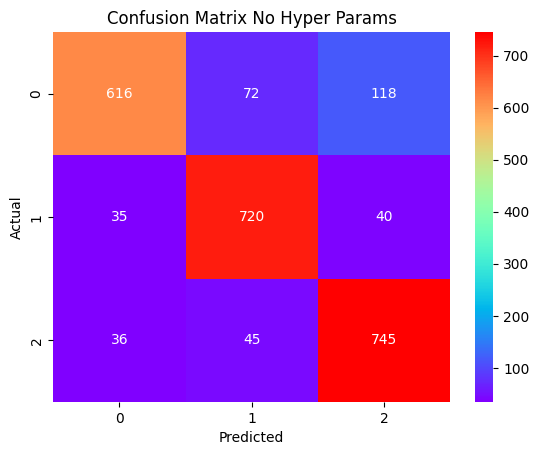

In [ ]:
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Plot the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap='rainbow')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix No Hyper Params")
plt.show()

/home/main/.local/share/virtualenvs/utk-spooky3times-O7BgMqzs/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


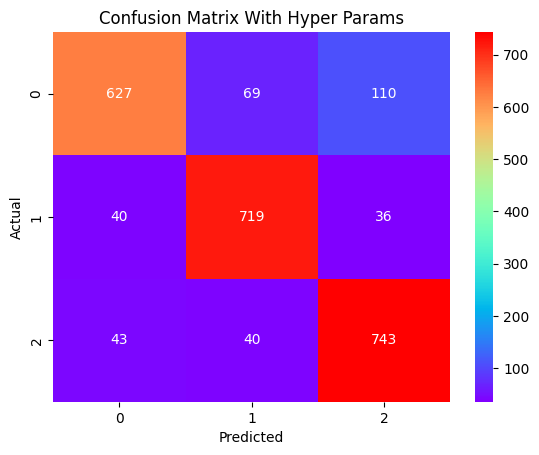

In [ ]:
metrics = MulticlassMetrics(cv_predictions.select("prediction", "label").rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Plot the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap='rainbow')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix With Hyper Params")
plt.show()

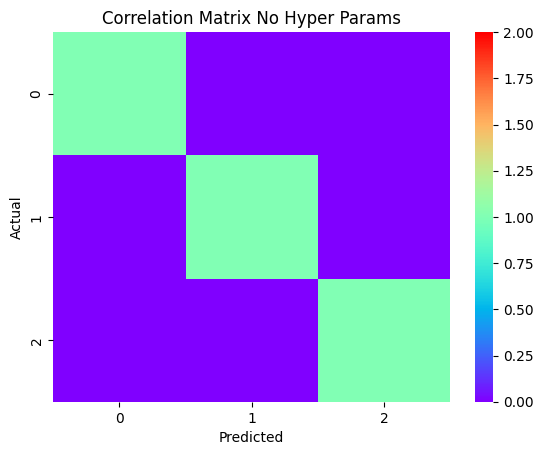

In [ ]:
# Correlation matrix
probabilities = predictions.select("probability")

# Convert probabilities to feature vector
assembler = VectorAssembler(inputCols=probabilities.columns, outputCol="features")
assembled_data = assembler.transform(probabilities).select("features")
correlation_matrix = Correlation.corr(assembled_data, "features").collect()[0][0].toArray()

plt.figure()
sns.heatmap(correlation_matrix, cmap="rainbow", vmin=0, vmax=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Correlation Matrix No Hyper Params")
plt.show()

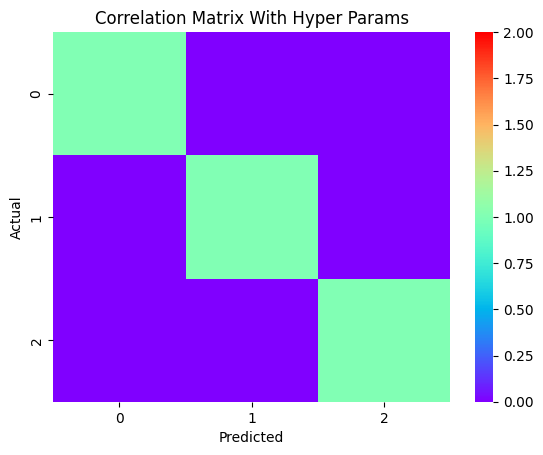

In [ ]:
# Correlation matrix
probabilities = cv_predictions.select("probability")

# Convert probabilities to feature vector
assembler = VectorAssembler(inputCols=probabilities.columns, outputCol="features")
assembled_data = assembler.transform(probabilities).select("features")
correlation_matrix = Correlation.corr(assembled_data, "features").collect()[0][0].toArray()

plt.figure()
sns.heatmap(correlation_matrix, cmap="rainbow", vmin=0, vmax=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Correlation Matrix With Hyper Params")
plt.show()

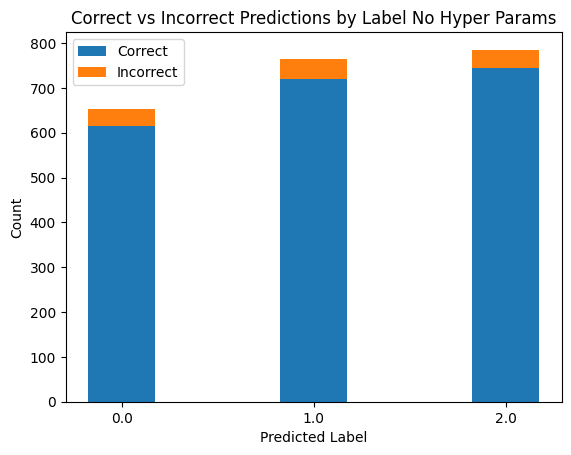

In [ ]:
# Extract the labels and counts
label_counts = predictions.groupBy("prediction", "label").count().orderBy("prediction", "label").collect()
predicted_labels = sorted(set(row["prediction"] for row in label_counts))
actual_labels = sorted(set(row["label"] for row in label_counts))

# correct and incorrect count lists
correct_counts = [0] * len(predicted_labels)
incorrect_counts = [0] * len(predicted_labels)

# counts based on the predictions
for row in label_counts:
    pred_label_idx = predicted_labels.index(row["prediction"])
    if row["prediction"] == row["label"]:
        correct_counts[pred_label_idx] = row["count"]
    else:
        incorrect_counts[pred_label_idx] = row["count"]

# bar chart
plt.figure()
bar_width = 0.35
index = range(len(predicted_labels))
plt.bar(index, correct_counts, bar_width, label="Correct")
plt.bar(index, incorrect_counts, bar_width, bottom=correct_counts, label="Incorrect")
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Correct vs Incorrect Predictions by Label No Hyper Params")
plt.xticks(index, predicted_labels)
plt.legend()
plt.show()

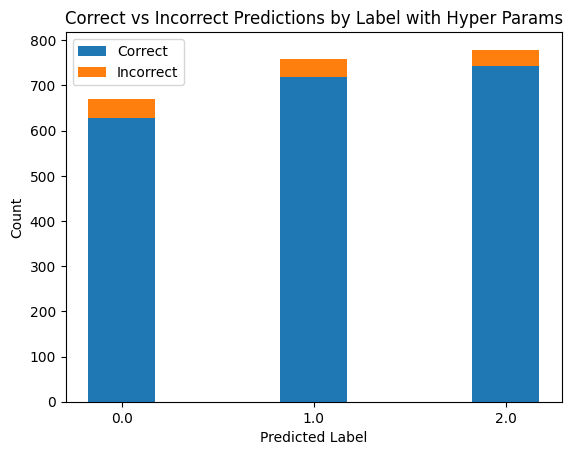

In [ ]:
# Extract the labels and counts
label_counts = cv_predictions.groupBy("prediction", "label").count().orderBy("prediction", "label").collect()
predicted_labels = sorted(set(row["prediction"] for row in label_counts))
actual_labels = sorted(set(row["label"] for row in label_counts))

# correct and incorrect count lists
correct_counts = [0] * len(predicted_labels)
incorrect_counts = [0] * len(predicted_labels)

# counts based on the predictions
for row in label_counts:
    pred_label_idx = predicted_labels.index(row["prediction"])
    if row["prediction"] == row["label"]:
        correct_counts[pred_label_idx] = row["count"]
    else:
        incorrect_counts[pred_label_idx] = row["count"]

# bar chart
plt.figure()
bar_width = 0.35
index = range(len(predicted_labels))
plt.bar(index, correct_counts, bar_width, label="Correct")
plt.bar(index, incorrect_counts, bar_width, bottom=correct_counts, label="Incorrect")
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Correct vs Incorrect Predictions by Label with Hyper Params")
plt.xticks(index, predicted_labels)
plt.legend()
plt.show()